# Collating Traning Results

The training results are parsed and summarized in this notebook

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *

Get the hyperparameters from the training logs.

In [2]:
# Path to train.log
path = "outputs/2024-04-11/07-26-56/train.log"

In [3]:
def read_log(path: Union[str, Path]):
    with open(path, "r") as f:
        lines = f.readlines()
    return lines

In [4]:
train_log = read_log(path)

In [5]:
tokens = ['src_data', 'model', 'embed_model', 'value_mode', 'task', 'transfer']

In [6]:
def create_pattern(token: str):
    return re.compile(r"'{}': '(\w+)'".format(token))

In [8]:
def parse_log(train_log: List[str], tokens: List[str]):
    hyperparams = {}
    for line in train_log:
        for tok in tokens:
            pattern = create_pattern(tok)
            match = pattern.search(line)
            if match:
                #print(match.group(1))
                hyperparams[tok] = match.group(1)
    return hyperparams


In [9]:
hyperparams = parse_log(train_log, tokens)

In [24]:
def get_trainlog_paths(root: Union[str, Path]):
    root = Path(root)
    return list(root.glob("*/*/train.log"))

In [32]:
def parse_experiment(root: Union[str, Path], tokens: List[str]):
    l_trainlogs = get_trainlog_paths(root)
    df = pd.DataFrame()
    for log in l_trainlogs:
        train_log = read_log(log)
        hyperparams = parse_log(train_log, tokens)
        run = log.parent.name
        hyperparams['run'] = run
        if "done training" in train_log[-1]:
            hyperparams['done'] = True
        else:
            hyperparams['done'] = False
        df = pd.concat([df, pd.DataFrame(hyperparams, index=[0])])
    return df

In [34]:
df_experiments = parse_experiment("outputs", tokens)

In [38]:
df_experiments.head(5)

,run,done,model,src_data,task,value_mode,embed_model
0,06-34-48,True,NaN,NaN,NaN,NaN,NaN
0,06-40-51,True,NaN,NaN,NaN,NaN,NaN
0,06-50-01,False,descemb_rnn,mimiciii,mlm,DSVA_DPE,NaN
0,06-50-26,False,descemb_rnn,mimiciii,mlm,DSVA_DPE,NaN
0,06-52-29,False,descemb_rnn,mimiciii,mlm,DSVA_DPE,NaN


In [37]:
df_experiments.to_excel("outputs/experiments.xlsx")

In [39]:
def create_pattern_numerical(token: str):
    return re.compile(r"{}: (\d+(\.\d+)?)".format(token))

In [43]:
folds = ["[train]", "[valid]", "[test]"]
history = {}
metrics = ['auroc', 'auprc', 'loss', 'epoch']
# create a pattern dictionay with the metrics as keys
patterns = {metric: create_pattern_numerical(metric) for metric in metrics}

In [41]:
for line in train_log:
    for fold in folds:
        history[fold] = pd.DataFrame(columns=metrics)
        for metric in metrics[:-1]:
            pattern = patterns[metric]
            if pattern.search(line):
                epoch = patterns['epoch'].search(line).group(1)
                history[fold].loc['epoch', metric] = pattern.search(line).group(1)
                #print(metric, pattern.search(line).group(1))

In [42]:
history

{'[train]': Empty DataFrame
 Columns: [auroc, auprc, loss, epoch]
 Index: [],
 '[valid]': Empty DataFrame
 Columns: [auroc, auprc, loss, epoch]
 Index: [],
 '[test]': Empty DataFrame
 Columns: [auroc, auprc, loss, epoch]
 Index: []}

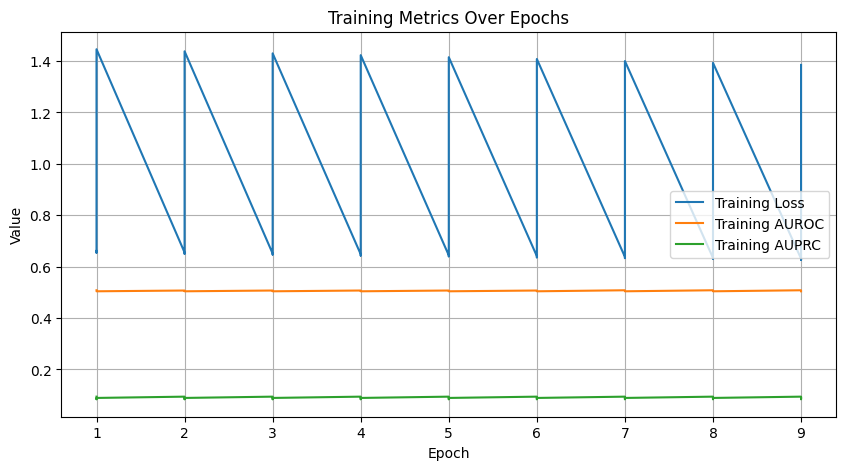

In [2]:


# Define regular expressions to extract relevant information
epoch_pattern = re.compile(r"epoch: (\d+)")
loss_pattern = re.compile(r"loss: ([\d.]+)")
auroc_pattern = re.compile(r"auroc: ([\d.]+)")
auprc_pattern = re.compile(r"auprc: ([\d.]+)")

# Initialize lists to store extracted data
epochs = []
train_losses = []
valid_losses = []
train_aurocs = []
valid_aurocs = []
train_auprcs = []
valid_auprcs = []


# Read the log file
with open(path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        epoch_match = epoch_pattern.search(line)
        if epoch_match:
            epoch = int(epoch_match.group(1))
            epochs.append(epoch)

            loss_match = loss_pattern.search(line)
            if loss_match:
                train_losses.append(float(loss_match.group(1)))

            auroc_match = auroc_pattern.search(line)
            if auroc_match:
                train_aurocs.append(float(auroc_match.group(1)))

            auprc_match = auprc_pattern.search(line)
            if auprc_match:
                train_auprcs.append(float(auprc_match.group(1)))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, train_aurocs, label='Training AUROC')
plt.plot(epochs, train_auprcs, label='Training AUPRC')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


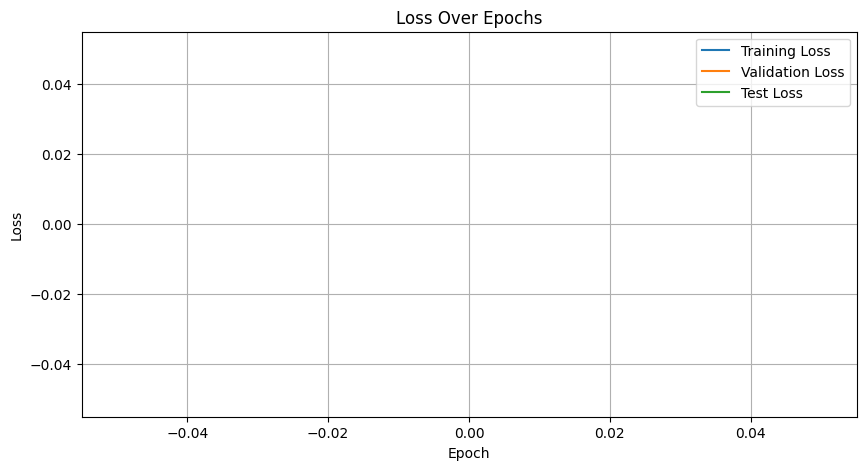

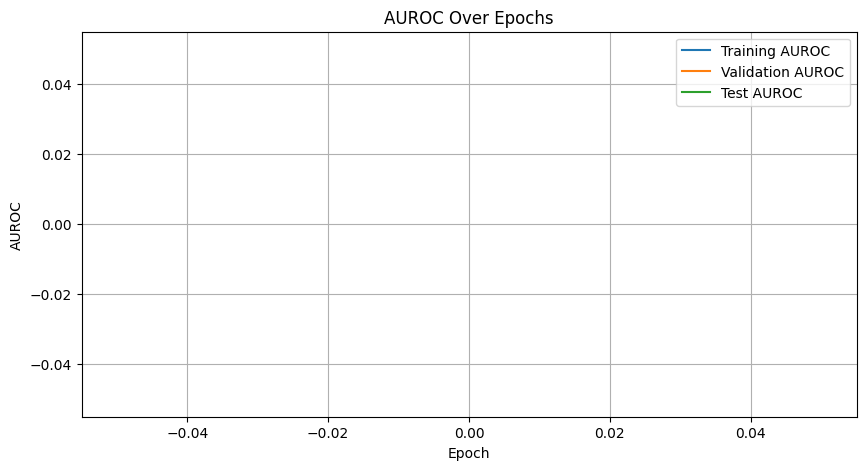

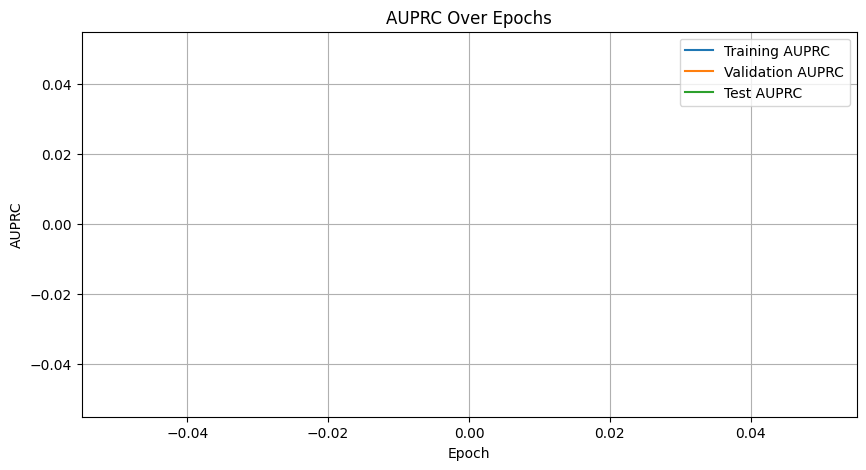

In [5]:
import re
import matplotlib.pyplot as plt

# Define regular expressions to extract relevant information
epoch_pattern = re.compile(r"epoch: (\d+)")
subset_pattern = re.compile(r"subset: (\w+)")
loss_pattern = re.compile(r"loss: ([\d.]+)")
auroc_pattern = re.compile(r"auroc: ([\d.]+)")
auprc_pattern = re.compile(r"auprc: ([\d.]+)")

# Initialize lists to store extracted data
epochs = {'train': [], 'valid': [], 'test': []}
losses = {'train': [], 'valid': [], 'test': []}
aurocs = {'train': [], 'valid': [], 'test': []}
auprcs = {'train': [], 'valid': [], 'test': []}

# Read the log file
with open(path, 'r') as file:
    lines = file.readlines()
    current_subset = None
    for line in lines:
        epoch_match = epoch_pattern.search(line)
        if epoch_match:
            epoch = int(epoch_match.group(1))

            subset_match = subset_pattern.search(line)
            if subset_match:
                current_subset = subset_match.group(1)
                epochs[current_subset].append(epoch)

                loss_match = loss_pattern.search(line)
                if loss_match:
                    losses[current_subset].append(float(loss_match.group(1)))

                auroc_match = auroc_pattern.search(line)
                if auroc_match:
                    aurocs[current_subset].append(float(auroc_match.group(1)))

                auprc_match = auprc_pattern.search(line)
                if auprc_match:
                    auprcs[current_subset].append(float(auprc_match.group(1)))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs['train'], losses['train'], label='Training Loss')
plt.plot(epochs['valid'], losses['valid'], label='Validation Loss')
plt.plot(epochs['test'], losses['test'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs['train'], aurocs['train'], label='Training AUROC')
plt.plot(epochs['valid'], aurocs['valid'], label='Validation AUROC')
plt.plot(epochs['test'], aurocs['test'], label='Test AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.title('AUROC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs['train'], auprcs['train'], label='Training AUPRC')
plt.plot(epochs['valid'], auprcs['valid'], label='Validation AUPRC')
plt.plot(epochs['test'], auprcs['test'], label='Test AUPRC')
plt.xlabel('Epoch')
plt.ylabel('AUPRC')
plt.title('AUPRC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def parse_train_log(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Define regular expressions to extract the columns
    pattern = r'\|\s+(\w+)\s+\|\s+(\w+)\s+\|\s+(\w+)\s+\|\s+(\w+)\s+\|\s+(\w+)\s+\|\s+(\w+)\s+\|\s+(\w+)\s+\|'
    columns = ['src_data', 'model', 'embed_model', 'value_mode', 'task', 'transfer', 'run_terminated']

    data = []

    # Iterate through each line in the file
    for line in lines:
        # Match the regular expression pattern
        match = re.match(pattern, line)
        if match:
            # Extract the values from the matched groups
            values = match.groups()
            # Create a dictionary mapping column names to values
            entry = dict(zip(columns, values))
            # Append the dictionary to the data list
            data.append(entry)

    # Create a pandas DataFrame from the parsed data
    df = pd.DataFrame(data)
    return df

# Parse train.log and display the DataFrame
train_log_df = parse_train_log(path)
print(train_log_df)

Empty DataFrame
Columns: []
Index: []


In [7]:
import pandas as pd